# ML CUP 2022 #

## Random Search with Keras #


This notebook creates a neural network using the framework Keras to generalize the problem of the ML cup 2022. it searches the best combination of hyperparameters performing a nested random search over a given range of values. Below there is a brief account about the implementation of the neural network.

hyperparameters considered for the random search:

1. Learning rate
2. The coefficient for momentum
3. Number of units of the hidden layers
4. the lambda coefficient for lasso regularisation (L1)
5. Number of hidden layers (1 against 2)

Model created using early stopping.\
Model selection performed using a cross validation.\
The model assessment phase in not included in this notebook



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers
from keras import metrics

from sklearn.utils import shuffle
from sklearn import model_selection

from operator import itemgetter

import keras.backend as K

2022-12-20 16:51:03.308798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 16:51:03.426260: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-20 16:51:03.426278: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-20 16:51:03.988666: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

Loading data for the ML cup 2022

In [2]:
# set a fixed seed
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
colnames = ['id', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'target1', 'target2']
mlcup_tr = pd.read_csv("./dataset/ml_cup22/ML-CUP22-TR.csv", sep = ",", names=colnames)
mlcup_tr = mlcup_tr.iloc[1:, :]
mlcup_tr = mlcup_tr.drop('id', axis=1)

In [4]:
x_mlcup_tr = mlcup_tr.iloc[:, 0:9].values
y_mlcup_tr = mlcup_tr.iloc[:, 9:11].values

Below there is the target's shape before the normalization

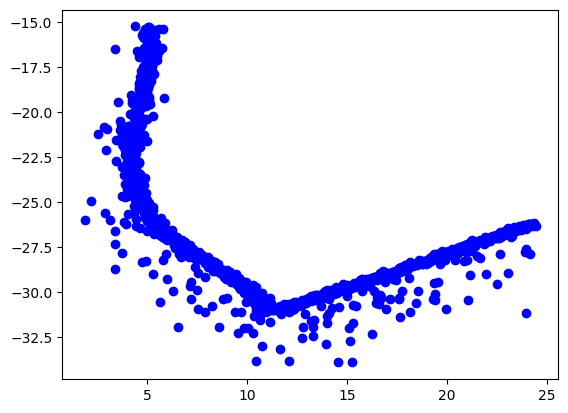

In [5]:
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1], color="blue")
plt.show()

## Data Normalization ##

Let's normalize our data performing a min-max normalization

In [6]:
x_cols = len(x_mlcup_tr[0])

max_col_value_x = [None]*x_cols
max_vl = None

min_col_value_x = [None]*x_cols
min_vl = None

for i in range(x_cols):
    col = x_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    x_mlcup_tr[:, i] = (x_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_x[i] = max_vl
    min_col_value_x[i] = min_vl
    
    
    
y_cols = len(y_mlcup_tr[0])

max_col_value_y = [None]*y_cols

min_col_value_y = [None]*y_cols

for i in range(y_cols):
    col = y_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    y_mlcup_tr[:, i] = (y_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_y[i] = max_vl
    min_col_value_y[i] = min_vl 

Below there is the target shape after the normalization

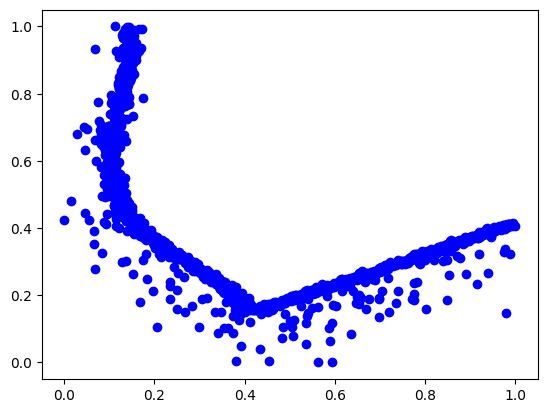

In [7]:
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1], color="blue")
plt.show()

## Neural Network with Random Search ##

Below we extended the RandomSearch class of the keras_tuner library to perform a cross validation during the phase of model selection (which is not supported by the RandomSearch class).

In [8]:
class CrossValidationRandomSearch(kt.RandomSearch):

    
    cross_validation_partitions = -1
    
    
    def __init__(
        self,
        hypermodel=None,
        objective=None,
        max_trials=10,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        folds_number=1,
        **kwargs
    ):
        self.cross_validation_partitions = model_selection.KFold(folds_number)
        
        
        kt.RandomSearch.__init__(
            self,
            hypermodel=hypermodel,
            objective=objective,
            max_trials=max_trials,
            seed=seed,
            hyperparameters=hyperparameters,
            tune_new_entries=tune_new_entries,
            allow_new_entries=allow_new_entries,
            **kwargs
        )

        
    def run_trial(self, trial, x_train, y_train, *args, **kwargs):
    
        histories_cv = []
        histories_folds = []
        # build a different model for each fold of the cross validation
        for train_indices, test_indices in self.cross_validation_partitions.split(x_train):
            x_cv_train, x_cv_val = x_train[train_indices], x_train[test_indices]
            y_cv_train, y_cv_val = y_train[train_indices], y_train[test_indices]
            histories_folds = super(CrossValidationRandomSearch, self).run_trial(
                trial, x_cv_train, y_cv_train, validation_data=(x_cv_val, y_cv_val), *args, **kwargs
            )
            histories_cv.append(histories_folds)

            histories_folds = []
        # return the performance of each model
        return histories_cv

Now we are about to define the mean Euclidean distance to use it as metric for the model.

In [9]:
# This function computes the mean euclidean distance for Keras
def euclidean_distance(y_true, y_pred):
    """
    mean Euclidean distance error
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return (K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))) 

Below we defined two functions; the first one is used to create a model given a combination of hyperparameters, while the second one select a random combination of hyperparameters in a given range

In [10]:
# instantiate a model given a specific combination of hyperparameters
def set_hyperparameters(units, lasso_lambda, learning_rate, momentum, double_layer, my_metric):
    model = Sequential()
    model.add(
        Dense(
            units=units,
            activity_regularizer=regularizers.L1(lasso_lambda),
            activation="relu",
        )
    )
    # if double_layer == True, a second layer for the NN is added
    if (double_layer):
        model.add(
            Dense(
                units=units,
                activity_regularizer=regularizers.L1(lasso_lambda),
                activation="relu"
            )
        )
    model.add(Dense(2, activation="linear", activity_regularizer=regularizers.L2(lasso_lambda)))

    
    # the optimizer is the stochastic gradient descent algorithm
    opt = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    model.compile(
        optimizer=opt, loss="mean_squared_error", metrics=[my_metric]
    )
    
    return model

# extract a random combination of hyperparamaters
def build_regressor(hp, my_metric,min_units=30, max_units=50, min_lasso_lambda=0.00001, max_lasso_lambda=0.01, min_lr_rate=0.05, 
                max_lr_rate=0.15, min_mom=0.0, max_mom=0.8, linear_lr=False, linear_reg=False, double_layer=False):
    
    
    learning_rate_sampling = "log"
    if (linear_lr):
        learning_rate_sampling = "linear"
    
    lasso_lambda_sampling = "log"
    if(linear_reg):
        lasso_lambda_sampling = "linear"
    
    units_step = 1
    if (max_units - min_units > 5):
        units_step = 3
    
    # the variable 'units' represents the number of units of the hidden layer
    # by default this value is extracted between 2 and 11 (the user can specify a different interval)
    units = hp.Int("units", min_value=min_units, max_value=max_units, step=units_step)
    
    # the variable 'lasso_lambda' represents the lambda coefficient for Lasso regularization (L1)
    # by default this value is extracted between 0.0001 and 0.1 with a logarithmic probabilistic law
    # (the user can specify a different interval)
    lasso_lambda = hp.Float(
        "lasso_lambda", min_value=min_lasso_lambda, max_value=max_lasso_lambda, sampling=lasso_lambda_sampling
    )
    
    # the variable 'learning rate' represents the step used by the stochastic gradient descent algorithm
    # by default this value is extracted between 0.1 and 0.6 (the user can specify a different interval)
    learning_rate = hp.Float(
        "learning_rate", min_value=min_lr_rate, max_value=max_lr_rate, sampling=learning_rate_sampling
    )
    
    # the variable 'momentum' represents the coefficient drawn for momentum
    # by default this value is extracted between 0.1 and 0.6 (the user can specify a different interval)
    momentum = hp.Float("momentum", min_value=min_mom, max_value=max_mom, sampling="linear")
    
    # Create the model with the set of hyperparameters drew
    model = set_hyperparameters(
        units=units, lasso_lambda=lasso_lambda, learning_rate=learning_rate, 
        momentum=momentum, double_layer=double_layer, my_metric=my_metric
    )
    return model

the function below was used to denormalize the targets predicted by the final model

In [11]:
def deNormalizer(pred_labels, max_col_value_y, min_col_value_y):
    
    y_cols = len(pred_labels[0])
    
    for i in range(y_cols):
        
        pred_labels[:, i] = pred_labels[:, i] * (max_col_value_y[i] - min_col_value_y[i]) + min_col_value_y[i]
    
    return pred_labels

compute the mean Euclidean error between the target and the predicted label

In [12]:
def compute_mean_euclidean_error(set1, set2):
    
    total_len = set1.shape[0]
    
    eu_dist = [None]*len(set1)
    
    for i in range(total_len):
        diff = set1[i] - set2[i]
        sum = 0
        for j in range(len(diff)):
            sum += math.pow(diff[j], 2)
        eu_dist[i] = math.sqrt(sum)
    
    sum = 0
    for i in range(len(eu_dist)):
        sum += eu_dist[i]
    
    final_vl = sum / len(eu_dist)
    return final_vl

Let's start searching randomly the best combination of hyperparameters using only one hidden layer.

In [13]:
br_l = lambda a : build_regressor(a, my_metric=euclidean_distance)

tuner = CrossValidationRandomSearch( 
    hypermodel=br_l, # function that return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts 
    executions_per_trial=2, # number of models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/single_layer/first/par_hp",
    folds_number=3, # number of folds of the cross validation
    distribution_strategy=tf.distribute.MirroredStrategy()
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2022-12-20 16:51:05.341901: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-20 16:51:05.341918: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-20 16:51:05.341935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (carlo-Aspire-A515-52G): /proc/driver/nvidia/version does not exist
2022-12-20 16:51:05.342126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


print a brief description of the search space

In [14]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 50, 'step': 3, 'sampling': None}
lasso_lambda (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.15, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': None, 'sampling': 'linear'}


In [15]:
tuner.search(
    # the training set for the model selection
    x_mlcup_tr, y_mlcup_tr,
    # maximum number of epochs allowed
    epochs=2500,
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True,
)

Trial 50 Complete [00h 04m 21s]
val_euclidean_distance: 0.08679227903485298

Best val_euclidean_distance So Far: 0.08425002172589302
Total elapsed time: 02h 15m 33s
INFO:tensorflow:Oracle triggered exit


In [16]:
best_hp = tuner.get_best_hyperparameters(3)

print("results of the first random search with a single hidden layer\n")
for i in range(len(best_hp)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "lasso_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp[i].get(h_param))
    print("")

results of the first random search with a single hidden layer

best hyperparameters n. 0
units 48
lasso_lambda 0.0009599552229374074
learning_rate 0.09331275884778358
momentum 0.6574145989262713

best hyperparameters n. 1
units 45
lasso_lambda 0.00018523889366274415
learning_rate 0.13752118435198502
momentum 0.4967185149471342

best hyperparameters n. 2
units 48
lasso_lambda 0.0002084976314756149
learning_rate 0.08203570840280965
momentum 0.7977930353953794



Brief description of the final neural network's structure

In [17]:
f_model = br_l(best_hp[0])
f_model.build(
input_shape=(None, 9))

f_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 48)                480       
                                                                 
 dense_3 (Dense)             (None, 2)                 98        
                                                                 
Total params: 578
Trainable params: 578
Non-trainable params: 0
_________________________________________________________________


In [18]:
tuner.results_summary()

Results summary
Results in results/ml_cup/nn_RandomSearch/single_layer/first/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 48
lasso_lambda: 0.0009599552229374074
learning_rate: 0.09331275884778358
momentum: 0.6574145989262713
Score: 0.08425002172589302
Trial summary
Hyperparameters:
units: 45
lasso_lambda: 0.00018523889366274415
learning_rate: 0.13752118435198502
momentum: 0.4967185149471342
Score: 0.08464394385615985
Trial summary
Hyperparameters:
units: 48
lasso_lambda: 0.0002084976314756149
learning_rate: 0.08203570840280965
momentum: 0.7977930353953794
Score: 0.08496268714467685
Trial summary
Hyperparameters:
units: 48
lasso_lambda: 0.0013609130414494806
learning_rate: 0.059166870515520664
momentum: 0.5916051757126345
Score: 0.08531168724099795
Trial summary
Hyperparameters:
units: 48
lasso_lambda: 0.005853743986176129
learning_rate: 0.09175077697015696
momentum: 0.12171267892301324
Score: 0.085349107782046
Trial summary
Hyperparameters:
units: 36
lasso_lambda

Now we have found a first best set of hyperparameters. At this point, we are ready to perform a second nested random search to explore the space around the best set of hyperparameters found.

In [19]:
h_param = ["units", "lasso_lambda", "learning_rate", "momentum"]

num_units = best_hp[0].get(h_param[0])
lasso_lambda = best_hp[0].get(h_param[1])
learning_rate = best_hp[0].get(h_param[2])
momentum = best_hp[0].get(h_param[3])
double_layer = False

lasso_lambda_min = (lasso_lambda / 10) * 8
lasso_lambda_max = (lasso_lambda / 10) * 12

learning_rate_min = (learning_rate / 10) * 8
learning_rate_max = (learning_rate / 10) * 12

momentum_min = (momentum / 10) * 8
momentum_max = (momentum / 10) * 12

# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l2 = lambda a: build_regressor(
    a, my_metric=euclidean_distance,
    min_units=num_units, max_units=num_units, min_lasso_lambda=lasso_lambda_min,
    max_lasso_lambda=lasso_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, 
    linear_lr=True, linear_reg=True, double_layer=double_layer
)

tuner2 = CrossValidationRandomSearch(
    hypermodel=br_l2, # function which return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/single_layer/nested/par_hp",
    folds_number=3, # number of folds of the cross validation
    distribution_strategy=tf.distribute.MirroredStrategy()
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Again, below there is a brief summary of the search space

In [20]:
tuner2.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 48, 'max_value': 48, 'step': 1, 'sampling': None}
lasso_lambda (Float)
{'default': 0.000767964178349926, 'conditions': [], 'min_value': 0.000767964178349926, 'max_value': 0.001151946267524889, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.07465020707822687, 'conditions': [], 'min_value': 0.07465020707822687, 'max_value': 0.1119753106173403, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.525931679141017, 'conditions': [], 'min_value': 0.525931679141017, 'max_value': 0.7888975187115255, 'step': None, 'sampling': 'linear'}


On the cell below we started the second nested random search (with again only one hidden layer)

In [21]:
tuner2.search(
    x_mlcup_tr, y_mlcup_tr, # training set for the random search 
    epochs=2500, # maximum number of epochs allowed
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 50 Complete [00h 02m 07s]
val_euclidean_distance: 0.08433385193347931

Best val_euclidean_distance So Far: 0.08298225825031598
Total elapsed time: 01h 48m 17s
INFO:tensorflow:Oracle triggered exit


Let's print again the best combination of hyperparameters found during this second nested random search

In [22]:
best_hp2 = tuner2.get_best_hyperparameters(3)

print("results of the second nested random search with a single hidden layer\n")
for i in range(len(best_hp2)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "lasso_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp2[i].get(h_param))
    print("")

results of the second nested random search with a single hidden layer

best hyperparameters n. 0
units 48
lasso_lambda 0.0011334321123355735
learning_rate 0.1026514542951379
momentum 0.7494838908480179

best hyperparameters n. 1
units 48
lasso_lambda 0.0010870104563358873
learning_rate 0.0876796856480846
momentum 0.7755271173459122

best hyperparameters n. 2
units 48
lasso_lambda 0.0008196764416419343
learning_rate 0.09239530888884842
momentum 0.7838367381767424



Brief description of the final neural network's structure

In [23]:
br_l2 = lambda a : build_regressor(a, my_metric=euclidean_distance)

f_model2 = br_l2(best_hp2[0])
f_model2.build(
input_shape=(None, 9))

f_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 48)                480       
                                                                 
 dense_3 (Dense)             (None, 2)                 98        
                                                                 
Total params: 578
Trainable params: 578
Non-trainable params: 0
_________________________________________________________________


At this point we tried many neural networks using the best hyperparameters found by the second nested random search. Below we split the design set between training set and validation set. Remember that here we are using only one hidden layer

In [24]:
subset_size = int(0.2 * len(x_mlcup_tr))

index = np.random.choice(len(x_mlcup_tr), subset_size, replace=False)
index = np.sort(index)

x_mlcup_ds = x_mlcup_tr
y_mlcup_ds = y_mlcup_tr

x_mlcup_vl = x_mlcup_ds[index]
y_mlcup_vl = y_mlcup_ds[index]

x_mlcup_tr = np.delete(x_mlcup_ds, index, 0)
y_mlcup_tr = np.delete(y_mlcup_ds, index, 0)

In [25]:
n_trials = 10

models = [None]*n_trials

for i in range(n_trials):
    models[i] = br_l2(best_hp2[0])

n_epochs = 1000
hist = [None]*n_trials

for i in range(n_trials):
        hist[i] = models[i].fit(
            x=x_mlcup_tr,
            y=y_mlcup_tr,
            validation_data=(x_mlcup_vl, y_mlcup_vl),
            epochs=n_epochs,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
30/30 [==============================] - 1s 7ms/step - loss: 0.0500 - euclidean_distance: 0.2272 - val_loss: 0.0189 - val_euclidean_distance: 0.1388
Epoch 2/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0177 - euclidean_distance: 0.1305 - val_loss: 0.0149 - val_euclidean_distance: 0.1187
Epoch 3/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0149 - euclidean_distance: 0.1173 - val_loss: 0.0132 - val_euclidean_distance: 0.1116
Epoch 4/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0131 - euclidean_distance: 0.1088 - val_loss: 0.0117 - val_euclidean_distance: 0.1035
Epoch 5/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0121 - euclidean_distance: 0.1057 - val_loss: 0.0111 - val_euclidean_distance: 0.1025
Epoch 6/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0115 - euclidean_distance: 0.1037 - val_loss: 0.0114 - val_euclidean_distance: 0.1046
Epoch 7/1000
30/30 [========

30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0921 - val_loss: 0.0085 - val_euclidean_distance: 0.0942
Epoch 16/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0920 - val_loss: 0.0085 - val_euclidean_distance: 0.0932
Epoch 17/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0083 - euclidean_distance: 0.0909 - val_loss: 0.0087 - val_euclidean_distance: 0.0967
Epoch 18/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0083 - euclidean_distance: 0.0910 - val_loss: 0.0086 - val_euclidean_distance: 0.0938
Epoch 19/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0082 - euclidean_distance: 0.0905 - val_loss: 0.0085 - val_euclidean_distance: 0.0938
Epoch 20/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0897 - val_loss: 0.0084 - val_euclidean_distance: 0.0952
Epoch 21/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0863 - val_loss: 0.0077 - val_euclidean_distance: 0.0898
Epoch 57/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0857 - val_loss: 0.0076 - val_euclidean_distance: 0.0890
Epoch 58/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0866 - val_loss: 0.0077 - val_euclidean_distance: 0.0908
Epoch 59/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0864 - val_loss: 0.0078 - val_euclidean_distance: 0.0925
Epoch 60/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0855 - val_loss: 0.0076 - val_euclidean_distance: 0.0910
Epoch 61/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0864 - val_loss: 0.0078 - val_euclidean_distance: 0.0900
Epoch 62/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0838 - val_loss: 0.0069 - val_euclidean_distance: 0.0845
Epoch 71/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0827 - val_loss: 0.0070 - val_euclidean_distance: 0.0855
Epoch 72/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0844 - val_loss: 0.0071 - val_euclidean_distance: 0.0852
Epoch 73/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0833 - val_loss: 0.0070 - val_euclidean_distance: 0.0841
Epoch 74/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0833 - val_loss: 0.0070 - val_euclidean_distance: 0.0847
Epoch 75/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0838 - val_loss: 0.0069 - val_euclidean_distance: 0.0855
Epoch 76/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0818 - val_loss: 0.0074 - val_euclidean_distance: 0.0868
Epoch 85/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0822 - val_loss: 0.0072 - val_euclidean_distance: 0.0861
Epoch 86/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0825 - val_loss: 0.0075 - val_euclidean_distance: 0.0885
Epoch 1/1000
30/30 [==============================] - 1s 6ms/step - loss: 0.0601 - euclidean_distance: 0.2615 - val_loss: 0.0162 - val_euclidean_distance: 0.1377
Epoch 2/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0158 - euclidean_distance: 0.1315 - val_loss: 0.0129 - val_euclidean_distance: 0.1159
Epoch 3/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0134 - euclidean_distance: 0.1179 - val_loss: 0.0115 - val_euclidean_distance: 0.1092
Epoch 4/1000
30/30 [===================

30/30 [==============================] - 0s 2ms/step - loss: 0.0089 - euclidean_distance: 0.0948 - val_loss: 0.0088 - val_euclidean_distance: 0.0955
Epoch 13/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0088 - euclidean_distance: 0.0943 - val_loss: 0.0086 - val_euclidean_distance: 0.0931
Epoch 14/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0087 - euclidean_distance: 0.0934 - val_loss: 0.0087 - val_euclidean_distance: 0.0949
Epoch 15/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0932 - val_loss: 0.0083 - val_euclidean_distance: 0.0933
Epoch 16/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0925 - val_loss: 0.0084 - val_euclidean_distance: 0.0933
Epoch 17/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0084 - euclidean_distance: 0.0925 - val_loss: 0.0085 - val_euclidean_distance: 0.0954
Epoch 18/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0875 - val_loss: 0.0071 - val_euclidean_distance: 0.0881
Epoch 50/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0876 - val_loss: 0.0076 - val_euclidean_distance: 0.0889
Epoch 51/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0869 - val_loss: 0.0071 - val_euclidean_distance: 0.0880
Epoch 52/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0888 - val_loss: 0.0073 - val_euclidean_distance: 0.0894
Epoch 53/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0875 - val_loss: 0.0071 - val_euclidean_distance: 0.0883
Epoch 54/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0865 - val_loss: 0.0071 - val_euclidean_distance: 0.0874
Epoch 55/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0836 - val_loss: 0.0070 - val_euclidean_distance: 0.0843
Epoch 1/1000
30/30 [==============================] - 1s 6ms/step - loss: 0.0591 - euclidean_distance: 0.2628 - val_loss: 0.0216 - val_euclidean_distance: 0.1613
Epoch 2/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0198 - euclidean_distance: 0.1516 - val_loss: 0.0160 - val_euclidean_distance: 0.1330
Epoch 3/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0155 - euclidean_distance: 0.1291 - val_loss: 0.0134 - val_euclidean_distance: 0.1189
Epoch 4/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0134 - euclidean_distance: 0.1178 - val_loss: 0.0117 - val_euclidean_distance: 0.1089
Epoch 5/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0120 - euclidean_distance: 0.1117 - val_loss: 0.0108 - val_euclidean_distance: 0.1056
Epoch 6/1000
30/30 [=====================

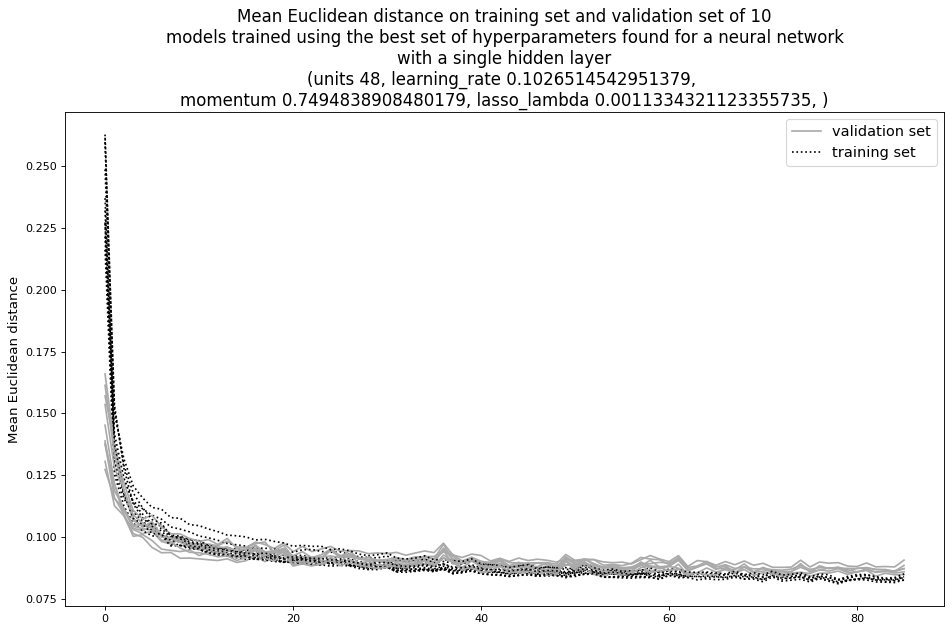

In [26]:
total_hp = 4
labels = ""
count = 1
for h_param in ["units", "learning_rate", "momentum", "lasso_lambda"]:
    labels += h_param + " " + str(best_hp2[0].get(h_param)) + ", "
    if(count % 2 == 0 and count != total_hp):
        labels += "\n"
    count += 1

list_values_val = [None]*n_trials
list_values_tr = [None]*n_trials

colours = ["darkgray", "black"]
linestyles = ["solid", "dotted"]

for i in range(n_trials):
    list_values_val[i] = hist[i].history['val_euclidean_distance']
    list_values_tr[i] = hist[i].history['euclidean_distance']
        
max_length = 0
for i in range(n_trials):
    if (max_length < len(list_values_tr[i])):
        max_length = len(list_values_tr[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values_val[i])], list_values_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values_tr[i])], list_values_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

legend = ["validation set", "training set"]

plt.title(
    "Mean Euclidean distance on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")", size=15
)

plt.ylabel("Mean Euclidean distance", size=12)
plt.legend(legend, prop={'size': 13})
plt.tight_layout()
plt.savefig("./plots/ml_cup/nn_RandomSearch/med_single_layer.png", bbox_inches='tight')
plt.show()

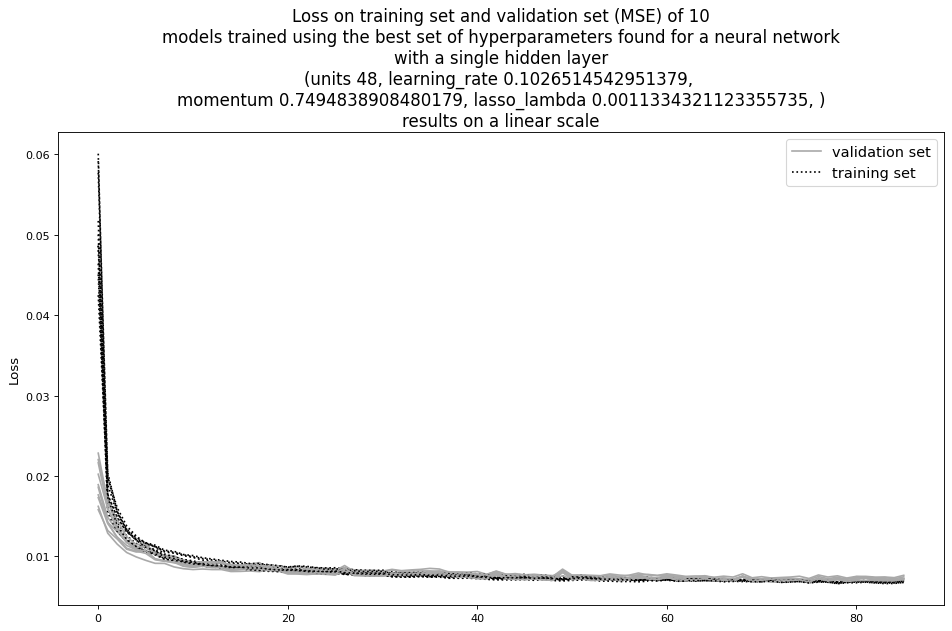

In [27]:
list_values2_val = [None]*n_trials
list_values2_tr = [None]*n_trials

for i in range(n_trials):
    list_values2_val[i] = hist[i].history['val_loss']
    list_values2_tr[i] = hist[i].history['loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set (MSE) of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")\n" +
    "results on a linear scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.tight_layout()
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_single_layer.png", bbox_inches='tight')
plt.show()

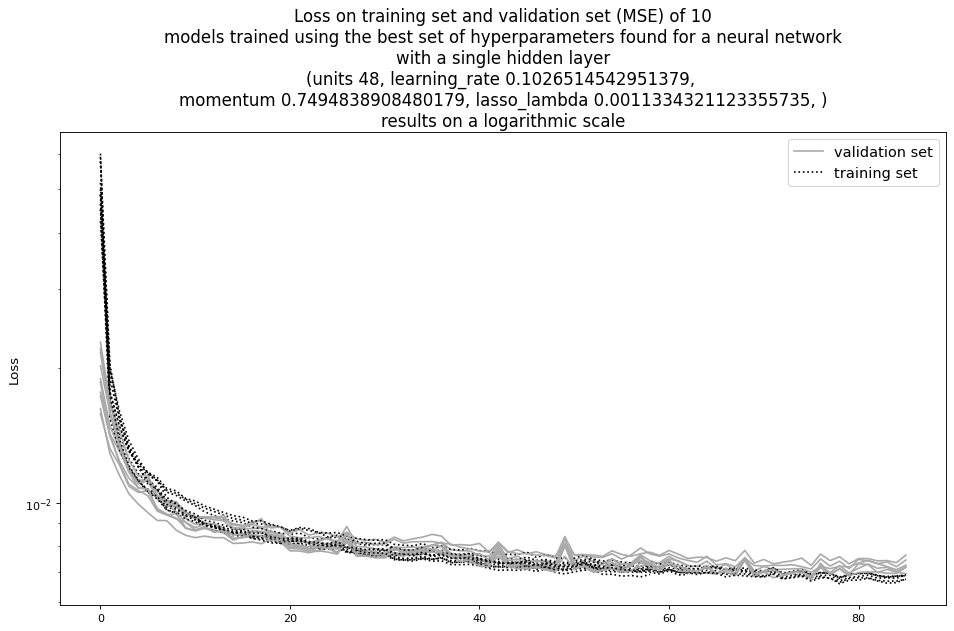

In [28]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set (MSE) of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")\n" +
    "results on a logarithmic scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.tight_layout()
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_single_layer_log.png", bbox_inches='tight')
plt.yscale('log')
plt.show()

At this point we tried to add a second hidden layer to study whether its presence could help the neural network to generalise the problem.

Therefore we restarted the random search from scratch

In [29]:
# Restore the original training set
x_mlcup_tr = x_mlcup_ds
y_mlcup_tr = y_mlcup_ds

num_units_min = 30
num_units_max = 50
double_layer = True


# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l = lambda a: build_regressor(
    a, my_metric=euclidean_distance, min_units=num_units_min,
    max_units=num_units_max, double_layer=double_layer
)


tuner3 = CrossValidationRandomSearch(
    hypermodel=br_l, # function that return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # number of models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/double_layer/first/par_hp",
    folds_number=3 # number of folds of the cross validation
)

print a brief description of the search space

In [30]:
tuner3.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 50, 'step': 3, 'sampling': None}
lasso_lambda (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.15, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': None, 'sampling': 'linear'}


In [31]:
tuner3.search(
    # the training set for the model selection
    x_mlcup_tr, y_mlcup_tr,
    # maximum number of epochs allowed
    epochs=2500,
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True,
)

Trial 50 Complete [00h 00m 44s]
val_euclidean_distance: 0.08268137276172638

Best val_euclidean_distance So Far: 0.0796096237997214
Total elapsed time: 01h 08m 29s
INFO:tensorflow:Oracle triggered exit


In [32]:
best_hp3 = tuner3.get_best_hyperparameters(3)

print("results of the first random search with a double hidden layer\n")
for i in range(len(best_hp3)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "lasso_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp3[i].get(h_param))
    print("")

results of the first random search with a double hidden layer

best hyperparameters n. 0
units 42
lasso_lambda 0.0016351366032192156
learning_rate 0.12391095910544114
momentum 0.635618952477109

best hyperparameters n. 1
units 42
lasso_lambda 0.0005913849909637554
learning_rate 0.09721131827443545
momentum 0.6218993796443526

best hyperparameters n. 2
units 42
lasso_lambda 0.0003534479144580234
learning_rate 0.10043956674764304
momentum 0.6526471038468443



Brief description of the final neural network's structure

In [33]:
br_l = lambda a: build_regressor(
    a, my_metric=euclidean_distance, double_layer=True
)

f_model3 = br_l(best_hp3[0])
f_model3.build(
input_shape=(None, 9))

f_model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 42)                420       
                                                                 
 dense_4 (Dense)             (None, 42)                1806      
                                                                 
 dense_5 (Dense)             (None, 2)                 86        
                                                                 
Total params: 2,312
Trainable params: 2,312
Non-trainable params: 0
_________________________________________________________________


In [34]:
tuner3.results_summary()

Results summary
Results in results/ml_cup/nn_RandomSearch/double_layer/first/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 42
lasso_lambda: 0.0016351366032192156
learning_rate: 0.12391095910544114
momentum: 0.635618952477109
Score: 0.0796096237997214
Trial summary
Hyperparameters:
units: 42
lasso_lambda: 0.0005913849909637554
learning_rate: 0.09721131827443545
momentum: 0.6218993796443526
Score: 0.07965475569168727
Trial summary
Hyperparameters:
units: 42
lasso_lambda: 0.0003534479144580234
learning_rate: 0.10043956674764304
momentum: 0.6526471038468443
Score: 0.07989947249492009
Trial summary
Hyperparameters:
units: 33
lasso_lambda: 0.0018298428168929712
learning_rate: 0.1151956319953919
momentum: 0.7576172511760656
Score: 0.08033695568641026
Trial summary
Hyperparameters:
units: 42
lasso_lambda: 0.0003204119265097899
learning_rate: 0.08614504174203459
momentum: 0.686535814980474
Score: 0.08051281546552976
Trial summary
Hyperparameters:
units: 39
lasso_lambda: 0.

Again, by now we have found a first best set of hyperparameters. We want to refine them by performing a second nested random search around this best combination of hyperparameters.

In [35]:
h_param = ["units", "lasso_lambda", "learning_rate", "momentum"]

num_units = best_hp3[0].get(h_param[0])
lasso_lambda = best_hp3[0].get(h_param[1])
learning_rate = best_hp3[0].get(h_param[2])
momentum = best_hp3[0].get(h_param[3])
double_layer = True

lasso_lambda_min = (lasso_lambda / 10) * 8
lasso_lambda_max = (lasso_lambda / 10) * 12

learning_rate_min = (learning_rate / 10) * 8
learning_rate_max = (learning_rate / 10) * 12

momentum_min = (momentum / 10) * 8
momentum_max = (momentum / 10) * 12

# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l2 = lambda a: build_regressor(
    a, my_metric=euclidean_distance, 
    min_units=num_units, max_units=num_units, min_lasso_lambda=lasso_lambda_min,
    max_lasso_lambda=lasso_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, linear_lr=True,
    linear_reg=True, double_layer=double_layer
)

tuner4 = CrossValidationRandomSearch(
    hypermodel=br_l2, # function which return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/double_layer/nested/par_hp",
    folds_number=3,
    distribution_strategy=tf.distribute.MirroredStrategy()
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Again, below there is a brief summary of the search space

In [36]:
tuner4.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 42, 'max_value': 42, 'step': 1, 'sampling': None}
lasso_lambda (Float)
{'default': 0.0013081092825753724, 'conditions': [], 'min_value': 0.0013081092825753724, 'max_value': 0.0019621639238630584, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.09912876728435291, 'conditions': [], 'min_value': 0.09912876728435291, 'max_value': 0.14869315092652935, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.5084951619816872, 'conditions': [], 'min_value': 0.5084951619816872, 'max_value': 0.7627427429725309, 'step': None, 'sampling': 'linear'}


In [ ]:
tuner4.search(
    x_mlcup_tr, y_mlcup_tr, # training set for the random search 
    epochs=2500, # maximum number of epochs allowed
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Let's print again the best combination of hyperparameters found during this second nested random search with two hidden layers

In [59]:
best_hp4 = tuner4.get_best_hyperparameters(3)

print("results of the second nested random search with a single hidden layer\n")
for i in range(len(best_hp4)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "lasso_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp4[i].get(h_param))
    print("")

results of the second nested random search with a single hidden layer

best hyperparameters n. 0
units 42
lasso_lambda 0.0015053821128778672
learning_rate 0.1282556035995267
momentum 0.7295025272708011

best hyperparameters n. 1
units 42
lasso_lambda 0.0016062871400873912
learning_rate 0.13450579925071546
momentum 0.6702143737743815

best hyperparameters n. 2
units 42
lasso_lambda 0.0017975910589461221
learning_rate 0.11849765269623437
momentum 0.5797350084729301



Brief description of the final neural network's structure

In [60]:
br_l2 = lambda a: build_regressor(
    a, my_metric=euclidean_distance, double_layer=True
)

f_model4 = br_l2(best_hp4[0])
f_model4.build(
input_shape=(None, 9))

f_model4.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 42)                420       
                                                                 
 dense_70 (Dense)            (None, 42)                1806      
                                                                 
 dense_71 (Dense)            (None, 2)                 86        
                                                                 
Total params: 2,312
Trainable params: 2,312
Non-trainable params: 0
_________________________________________________________________


At this point we tried many neural networks using the best hyperparameters found by the second nested random search. Below we split the design set between training set and validation set. Remember that here we are using two hidden layers

In [61]:
subset_size = int(0.2 * len(x_mlcup_tr))

index = np.random.choice(len(x_mlcup_tr), subset_size, replace=False)
index = np.sort(index)

x_mlcup_ds = x_mlcup_tr
y_mlcup_ds = y_mlcup_tr

x_mlcup_vl = x_mlcup_ds[index]
y_mlcup_vl = y_mlcup_ds[index]

x_mlcup_tr = np.delete(x_mlcup_ds, index, 0)
y_mlcup_tr = np.delete(y_mlcup_ds, index, 0)

In [62]:
n_trials = 10

models2 = [None]*n_trials

for i in range(n_trials):
    models2[i] = br_l2(best_hp4[0])

n_epochs = 1000
hist2 = [None]*n_trials

for i in range(n_trials):
        hist2[i] = models2[i].fit(
            x=x_mlcup_tr,
            y=y_mlcup_tr,
            validation_data=(x_mlcup_vl, y_mlcup_vl),
            epochs=n_epochs,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
20/20 [==============================] - 1s 10ms/step - loss: 0.0678 - euclidean_distance: 0.2701 - val_loss: 0.0295 - val_euclidean_distance: 0.1693
Epoch 2/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0238 - euclidean_distance: 0.1458 - val_loss: 0.0255 - val_euclidean_distance: 0.1489
Epoch 3/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0201 - euclidean_distance: 0.1288 - val_loss: 0.0189 - val_euclidean_distance: 0.1264
Epoch 4/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0178 - euclidean_distance: 0.1193 - val_loss: 0.0190 - val_euclidean_distance: 0.1266
Epoch 5/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0167 - euclidean_distance: 0.1160 - val_loss: 0.0151 - val_euclidean_distance: 0.1095
Epoch 6/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.0153 - euclidean_distance: 0.1109 - val_loss: 0.0145 - val_euclidean_distance: 0.1073
Epoch 7/1000
20/20 [=======

20/20 [==============================] - 0s 3ms/step - loss: 0.0092 - euclidean_distance: 0.0883 - val_loss: 0.0085 - val_euclidean_distance: 0.0838
Epoch 52/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0089 - euclidean_distance: 0.0865 - val_loss: 0.0085 - val_euclidean_distance: 0.0831
Epoch 53/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0090 - euclidean_distance: 0.0867 - val_loss: 0.0095 - val_euclidean_distance: 0.0949
Epoch 54/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0088 - euclidean_distance: 0.0864 - val_loss: 0.0087 - val_euclidean_distance: 0.0848
Epoch 55/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0088 - euclidean_distance: 0.0862 - val_loss: 0.0084 - val_euclidean_distance: 0.0837
Epoch 56/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0090 - euclidean_distance: 0.0876 - val_loss: 0.0083 - val_euclidean_distance: 0.0822
Epoch 57/1000
20/20 [===============

20/20 [==============================] - 0s 3ms/step - loss: 0.0106 - euclidean_distance: 0.0930 - val_loss: 0.0104 - val_euclidean_distance: 0.0931
Epoch 22/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0107 - euclidean_distance: 0.0929 - val_loss: 0.0106 - val_euclidean_distance: 0.0957
Epoch 23/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0103 - euclidean_distance: 0.0913 - val_loss: 0.0096 - val_euclidean_distance: 0.0883
Epoch 24/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0101 - euclidean_distance: 0.0891 - val_loss: 0.0093 - val_euclidean_distance: 0.0864
Epoch 25/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0103 - euclidean_distance: 0.0917 - val_loss: 0.0102 - val_euclidean_distance: 0.0918
Epoch 26/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0102 - euclidean_distance: 0.0910 - val_loss: 0.0098 - val_euclidean_distance: 0.0906
Epoch 27/1000
20/20 [===============

20/20 [==============================] - 0s 3ms/step - loss: 0.0078 - euclidean_distance: 0.0813 - val_loss: 0.0084 - val_euclidean_distance: 0.0835
Epoch 72/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0082 - euclidean_distance: 0.0853 - val_loss: 0.0074 - val_euclidean_distance: 0.0776
Epoch 73/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0084 - euclidean_distance: 0.0850 - val_loss: 0.0093 - val_euclidean_distance: 0.0898
Epoch 74/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0085 - euclidean_distance: 0.0858 - val_loss: 0.0081 - val_euclidean_distance: 0.0827
Epoch 75/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0078 - euclidean_distance: 0.0814 - val_loss: 0.0072 - val_euclidean_distance: 0.0768
Epoch 76/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0078 - euclidean_distance: 0.0815 - val_loss: 0.0075 - val_euclidean_distance: 0.0786
Epoch 77/1000
20/20 [===============

20/20 [==============================] - 0s 3ms/step - loss: 0.0106 - euclidean_distance: 0.0913 - val_loss: 0.0104 - val_euclidean_distance: 0.0934
Epoch 23/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0103 - euclidean_distance: 0.0917 - val_loss: 0.0098 - val_euclidean_distance: 0.0902
Epoch 24/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0101 - euclidean_distance: 0.0885 - val_loss: 0.0095 - val_euclidean_distance: 0.0859
Epoch 25/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0105 - euclidean_distance: 0.0920 - val_loss: 0.0118 - val_euclidean_distance: 0.1015
Epoch 26/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0108 - euclidean_distance: 0.0941 - val_loss: 0.0095 - val_euclidean_distance: 0.0883
Epoch 27/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0099 - euclidean_distance: 0.0880 - val_loss: 0.0091 - val_euclidean_distance: 0.0857
Epoch 28/1000
20/20 [===============

20/20 [==============================] - 0s 3ms/step - loss: 0.0104 - euclidean_distance: 0.0924 - val_loss: 0.0107 - val_euclidean_distance: 0.0971
Epoch 23/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0100 - euclidean_distance: 0.0911 - val_loss: 0.0091 - val_euclidean_distance: 0.0857
Epoch 24/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0098 - euclidean_distance: 0.0881 - val_loss: 0.0088 - val_euclidean_distance: 0.0828
Epoch 25/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0098 - euclidean_distance: 0.0897 - val_loss: 0.0103 - val_euclidean_distance: 0.0938
Epoch 26/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0100 - euclidean_distance: 0.0911 - val_loss: 0.0092 - val_euclidean_distance: 0.0878
Epoch 27/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0095 - euclidean_distance: 0.0888 - val_loss: 0.0087 - val_euclidean_distance: 0.0828
Epoch 28/1000
20/20 [===============

20/20 [==============================] - 0s 3ms/step - loss: 0.0080 - euclidean_distance: 0.0838 - val_loss: 0.0074 - val_euclidean_distance: 0.0773
Epoch 73/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0082 - euclidean_distance: 0.0834 - val_loss: 0.0100 - val_euclidean_distance: 0.0929
Epoch 74/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0083 - euclidean_distance: 0.0852 - val_loss: 0.0087 - val_euclidean_distance: 0.0845
Epoch 75/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0077 - euclidean_distance: 0.0797 - val_loss: 0.0073 - val_euclidean_distance: 0.0765
Epoch 76/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0076 - euclidean_distance: 0.0797 - val_loss: 0.0076 - val_euclidean_distance: 0.0801
Epoch 77/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0076 - euclidean_distance: 0.0801 - val_loss: 0.0081 - val_euclidean_distance: 0.0838
Epoch 78/1000
20/20 [===============

20/20 [==============================] - 0s 3ms/step - loss: 0.0071 - euclidean_distance: 0.0771 - val_loss: 0.0072 - val_euclidean_distance: 0.0771
Epoch 123/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0072 - euclidean_distance: 0.0777 - val_loss: 0.0076 - val_euclidean_distance: 0.0820
Epoch 124/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0071 - euclidean_distance: 0.0785 - val_loss: 0.0079 - val_euclidean_distance: 0.0822
Epoch 125/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0072 - euclidean_distance: 0.0780 - val_loss: 0.0091 - val_euclidean_distance: 0.0890
Epoch 1/1000
20/20 [==============================] - 1s 10ms/step - loss: 0.0525 - euclidean_distance: 0.2308 - val_loss: 0.0346 - val_euclidean_distance: 0.1778
Epoch 2/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0261 - euclidean_distance: 0.1407 - val_loss: 0.0268 - val_euclidean_distance: 0.1481
Epoch 3/1000
20/20 [==============

20/20 [==============================] - 0s 3ms/step - loss: 0.0087 - euclidean_distance: 0.0848 - val_loss: 0.0098 - val_euclidean_distance: 0.0945
Epoch 48/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0091 - euclidean_distance: 0.0882 - val_loss: 0.0085 - val_euclidean_distance: 0.0860
Epoch 49/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0087 - euclidean_distance: 0.0852 - val_loss: 0.0081 - val_euclidean_distance: 0.0813
Epoch 50/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0085 - euclidean_distance: 0.0836 - val_loss: 0.0097 - val_euclidean_distance: 0.0924
Epoch 51/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0089 - euclidean_distance: 0.0857 - val_loss: 0.0080 - val_euclidean_distance: 0.0798
Epoch 52/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0085 - euclidean_distance: 0.0837 - val_loss: 0.0080 - val_euclidean_distance: 0.0804
Epoch 53/1000
20/20 [===============

20/20 [==============================] - 0s 2ms/step - loss: 0.0163 - euclidean_distance: 0.1135 - val_loss: 0.0173 - val_euclidean_distance: 0.1222
Epoch 5/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0156 - euclidean_distance: 0.1125 - val_loss: 0.0140 - val_euclidean_distance: 0.1055
Epoch 6/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0141 - euclidean_distance: 0.1056 - val_loss: 0.0144 - val_euclidean_distance: 0.1086
Epoch 7/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0136 - euclidean_distance: 0.1032 - val_loss: 0.0131 - val_euclidean_distance: 0.1019
Epoch 8/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0129 - euclidean_distance: 0.1008 - val_loss: 0.0120 - val_euclidean_distance: 0.0973
Epoch 9/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0126 - euclidean_distance: 0.1003 - val_loss: 0.0117 - val_euclidean_distance: 0.0948
Epoch 10/1000
20/20 [====================

20/20 [==============================] - 0s 3ms/step - loss: 0.0084 - euclidean_distance: 0.0840 - val_loss: 0.0087 - val_euclidean_distance: 0.0832
Epoch 55/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0087 - euclidean_distance: 0.0851 - val_loss: 0.0083 - val_euclidean_distance: 0.0819
Epoch 56/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0086 - euclidean_distance: 0.0855 - val_loss: 0.0082 - val_euclidean_distance: 0.0808
Epoch 57/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0085 - euclidean_distance: 0.0848 - val_loss: 0.0095 - val_euclidean_distance: 0.0923
Epoch 58/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0085 - euclidean_distance: 0.0850 - val_loss: 0.0085 - val_euclidean_distance: 0.0843
Epoch 59/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0084 - euclidean_distance: 0.0846 - val_loss: 0.0089 - val_euclidean_distance: 0.0886
Epoch 60/1000
20/20 [===============

20/20 [==============================] - 0s 3ms/step - loss: 0.0094 - euclidean_distance: 0.0878 - val_loss: 0.0088 - val_euclidean_distance: 0.0844
Epoch 34/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0094 - euclidean_distance: 0.0877 - val_loss: 0.0086 - val_euclidean_distance: 0.0837
Epoch 35/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0090 - euclidean_distance: 0.0857 - val_loss: 0.0096 - val_euclidean_distance: 0.0923
Epoch 36/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0091 - euclidean_distance: 0.0863 - val_loss: 0.0089 - val_euclidean_distance: 0.0854
Epoch 37/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0092 - euclidean_distance: 0.0868 - val_loss: 0.0086 - val_euclidean_distance: 0.0849
Epoch 38/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0093 - euclidean_distance: 0.0873 - val_loss: 0.0113 - val_euclidean_distance: 0.1033
Epoch 39/1000
20/20 [===============

20/20 [==============================] - 0s 3ms/step - loss: 0.0103 - euclidean_distance: 0.0930 - val_loss: 0.0095 - val_euclidean_distance: 0.0884
Epoch 30/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0099 - euclidean_distance: 0.0901 - val_loss: 0.0101 - val_euclidean_distance: 0.0915
Epoch 31/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0099 - euclidean_distance: 0.0908 - val_loss: 0.0119 - val_euclidean_distance: 0.1089
Epoch 32/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0104 - euclidean_distance: 0.0963 - val_loss: 0.0113 - val_euclidean_distance: 0.1029
Epoch 33/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0100 - euclidean_distance: 0.0915 - val_loss: 0.0091 - val_euclidean_distance: 0.0865
Epoch 34/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0101 - euclidean_distance: 0.0934 - val_loss: 0.0090 - val_euclidean_distance: 0.0859
Epoch 35/1000
20/20 [===============

20/20 [==============================] - 0s 3ms/step - loss: 0.0084 - euclidean_distance: 0.0847 - val_loss: 0.0084 - val_euclidean_distance: 0.0877
Epoch 80/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0080 - euclidean_distance: 0.0812 - val_loss: 0.0077 - val_euclidean_distance: 0.0796
Epoch 81/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0086 - euclidean_distance: 0.0861 - val_loss: 0.0079 - val_euclidean_distance: 0.0834
Epoch 82/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0080 - euclidean_distance: 0.0824 - val_loss: 0.0077 - val_euclidean_distance: 0.0819
Epoch 83/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0082 - euclidean_distance: 0.0839 - val_loss: 0.0076 - val_euclidean_distance: 0.0787
Epoch 84/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0079 - euclidean_distance: 0.0815 - val_loss: 0.0080 - val_euclidean_distance: 0.0801
Epoch 85/1000
20/20 [===============

20/20 [==============================] - 0s 3ms/step - loss: 0.0118 - euclidean_distance: 0.1027 - val_loss: 0.0111 - val_euclidean_distance: 0.0996
Epoch 27/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0108 - euclidean_distance: 0.0959 - val_loss: 0.0098 - val_euclidean_distance: 0.0889
Epoch 28/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0108 - euclidean_distance: 0.0956 - val_loss: 0.0116 - val_euclidean_distance: 0.1039
Epoch 29/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0113 - euclidean_distance: 0.0999 - val_loss: 0.0097 - val_euclidean_distance: 0.0886
Epoch 30/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0105 - euclidean_distance: 0.0937 - val_loss: 0.0100 - val_euclidean_distance: 0.0912
Epoch 31/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0103 - euclidean_distance: 0.0930 - val_loss: 0.0127 - val_euclidean_distance: 0.1164
Epoch 32/1000
20/20 [===============

20/20 [==============================] - 0s 3ms/step - loss: 0.0084 - euclidean_distance: 0.0845 - val_loss: 0.0082 - val_euclidean_distance: 0.0835
Epoch 77/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0085 - euclidean_distance: 0.0852 - val_loss: 0.0081 - val_euclidean_distance: 0.0828
Epoch 78/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0084 - euclidean_distance: 0.0840 - val_loss: 0.0079 - val_euclidean_distance: 0.0808
Epoch 79/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0086 - euclidean_distance: 0.0865 - val_loss: 0.0077 - val_euclidean_distance: 0.0799
Epoch 80/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0082 - euclidean_distance: 0.0830 - val_loss: 0.0077 - val_euclidean_distance: 0.0799
Epoch 81/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0089 - euclidean_distance: 0.0880 - val_loss: 0.0080 - val_euclidean_distance: 0.0844
Epoch 82/1000
20/20 [===============

20/20 [==============================] - 0s 3ms/step - loss: 0.0101 - euclidean_distance: 0.0901 - val_loss: 0.0096 - val_euclidean_distance: 0.0886
Epoch 24/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0099 - euclidean_distance: 0.0888 - val_loss: 0.0097 - val_euclidean_distance: 0.0900
Epoch 25/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0105 - euclidean_distance: 0.0926 - val_loss: 0.0110 - val_euclidean_distance: 0.0993
Epoch 26/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0103 - euclidean_distance: 0.0924 - val_loss: 0.0106 - val_euclidean_distance: 0.0967
Epoch 27/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0097 - euclidean_distance: 0.0884 - val_loss: 0.0094 - val_euclidean_distance: 0.0880
Epoch 28/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0096 - euclidean_distance: 0.0872 - val_loss: 0.0096 - val_euclidean_distance: 0.0890
Epoch 29/1000
20/20 [===============

20/20 [==============================] - 0s 3ms/step - loss: 0.0086 - euclidean_distance: 0.0844 - val_loss: 0.0097 - val_euclidean_distance: 0.0924
Epoch 74/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0083 - euclidean_distance: 0.0831 - val_loss: 0.0076 - val_euclidean_distance: 0.0791
Epoch 75/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0077 - euclidean_distance: 0.0783 - val_loss: 0.0075 - val_euclidean_distance: 0.0759
Epoch 76/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0078 - euclidean_distance: 0.0797 - val_loss: 0.0075 - val_euclidean_distance: 0.0766
Epoch 77/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0078 - euclidean_distance: 0.0799 - val_loss: 0.0077 - val_euclidean_distance: 0.0795
Epoch 78/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.0078 - euclidean_distance: 0.0782 - val_loss: 0.0076 - val_euclidean_distance: 0.0802
Epoch 79/1000
20/20 [===============

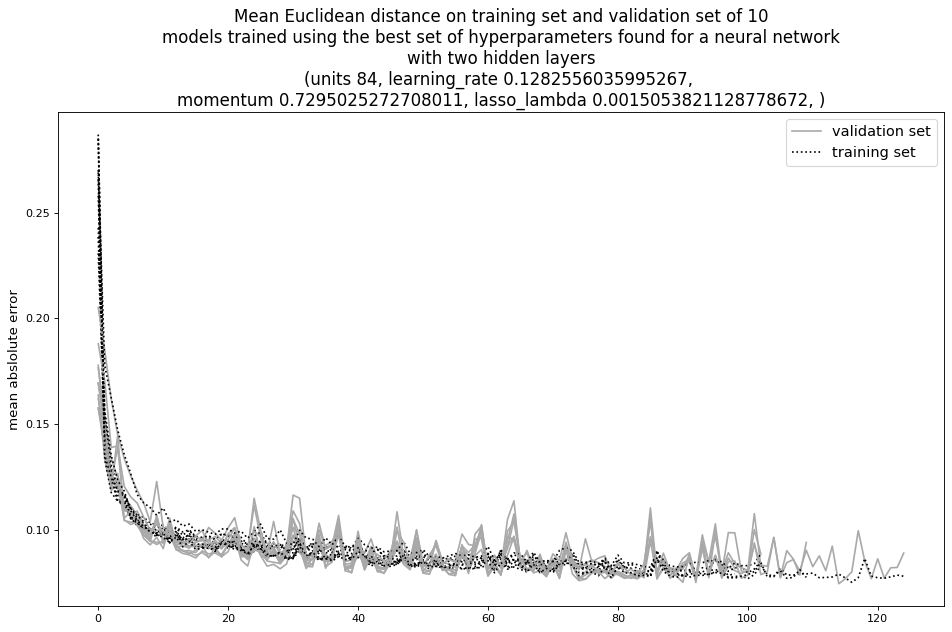

In [63]:
total_hp = 4
labels2 = ""
count = 1
for h_param in ["units", "learning_rate", "momentum", "lasso_lambda"]:
    hp_str = best_hp4[0].get(h_param)
    if (h_param == 'units'):
        hp_str *= 2
    labels2 += h_param + " " + str(hp_str) + ", "
    if(count % 2 == 0 and count != total_hp):
        labels2 += "\n"
    count += 1

list_values_val = [None]*n_trials
list_values_tr = [None]*n_trials

colours = ["darkgray", "black"]
linestyles = ["solid", "dotted"]

for i in range(n_trials):
    list_values_val[i] = hist2[i].history['val_euclidean_distance']
    list_values_tr[i] = hist2[i].history['euclidean_distance']
        
max_length = 0
for i in range(n_trials):
    if (max_length < len(list_values_tr[i])):
        max_length = len(list_values_tr[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values_val[i])], list_values_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values_tr[i])], list_values_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

legend = ["validation set", "training set"]

plt.title(
    "Mean Euclidean distance on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")", size=15
)

plt.ylabel("mean abslolute error", size=12)
plt.legend(legend, prop={'size': 13})
plt.tight_layout()
plt.savefig("./plots/ml_cup/nn_RandomSearch/med_double_layer.png", bbox_inches='tight')
plt.show()

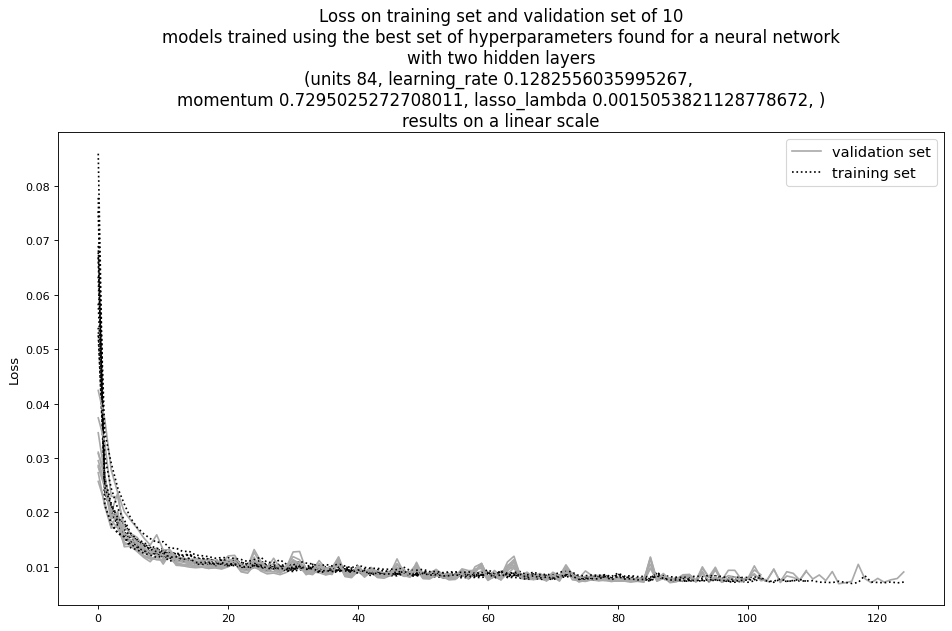

In [64]:
list_values2_val = [None]*n_trials
list_values2_tr = [None]*n_trials

for i in range(n_trials):
    list_values2_val[i] = hist2[i].history['val_loss']
    list_values2_tr[i] = hist2[i].history['loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")\n" +
    "results on a linear scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.tight_layout()
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_double_layer.png", bbox_inches='tight')
plt.show()

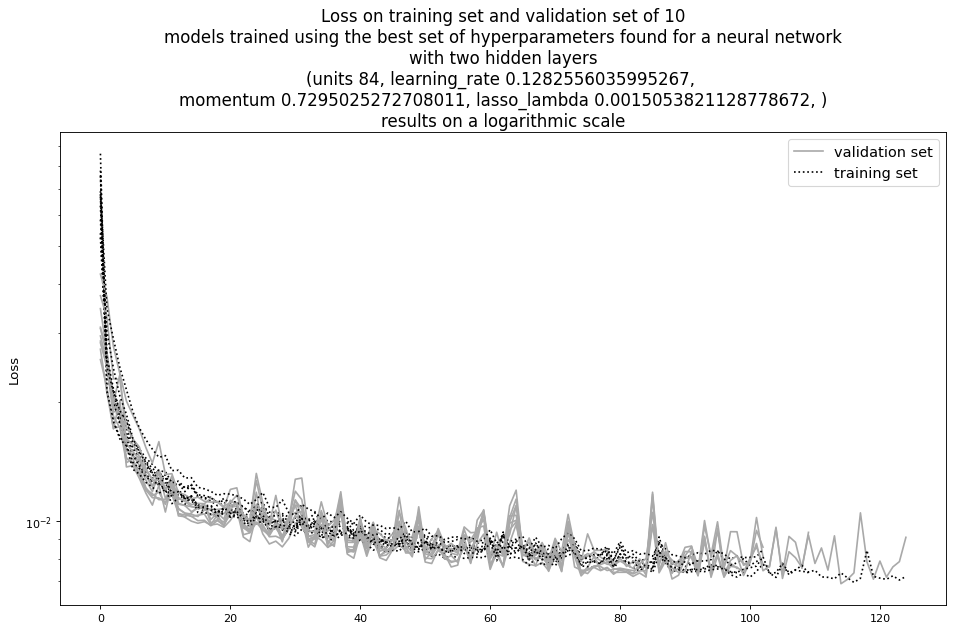

In [65]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")\n" +
    "results on a logarithmic scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_double_layer_log.png", bbox_inches='tight')
plt.tight_layout()
plt.yscale('log')
plt.show()

Let us know birefly compare the final scores reached by the models with two hidden layers and with just one

In [66]:
for i in range(n_trials):
    list_values_val[i] = hist[i].history['val_euclidean_distance']

print("Final score reached by the model with one hidden layer")
for i in range(10):
    a = list_values_val[i][len(list_values_val[i])-1]
    print("model", i, "final mean Euclidean error:", a)
    
predicted_target_ds = models2[0](x_mlcup_ds)


for i in range(n_trials):
    list_values_val[i] = hist2[i].history['val_euclidean_distance']

print("\nFinal score reached by the model with two hidden layers")
for i in range(10):
    a = list_values_val[i][len(list_values_val[i])-1]
    print("model", i, "final mean Euclidean error:", a)
    
predicted_target_ds = models2[0](x_mlcup_ds)

Final score reached by the model with one hidden layer
model 0 final mean Euclidean error: 0.08710751682519913
model 1 final mean Euclidean error: 0.08726389706134796
model 2 final mean Euclidean error: 0.09060417115688324
model 3 final mean Euclidean error: 0.08477779477834702
model 4 final mean Euclidean error: 0.08847501128911972
model 5 final mean Euclidean error: 0.08586633950471878
model 6 final mean Euclidean error: 0.08718081563711166
model 7 final mean Euclidean error: 0.08720406889915466
model 8 final mean Euclidean error: 0.08425633609294891
model 9 final mean Euclidean error: 0.08834023773670197

Final score reached by the model with two hidden layers
model 0 final mean Euclidean error: 0.08166054636240005
model 1 final mean Euclidean error: 0.08175817131996155
model 2 final mean Euclidean error: 0.09202299267053604
model 3 final mean Euclidean error: 0.08896244317293167
model 4 final mean Euclidean error: 0.07759024202823639
model 5 final mean Euclidean error: 0.0845169499

Comparing the final scores reached by the models with one single hidden layer and with two, we found out that the models with two distinct hidden layers performed slightly better. For this reason we retrieved as final model, one among the neural network with two hidden layers. To avoid overfitting, we didn't choose the best model among those with two hidden layers, but the third one (out of 10).

In [81]:
# double hidden layer (retrieve the model with the median error)

rank = 3

for i in range(n_trials):
    list_values_val[i] = hist2[i].history['val_euclidean_distance']

final_values_val = [None]*n_trials
for i in range(n_trials):
    final_values_val[i] = list_values_val[i][len(list_values_val[i]) - 1]

list_scores = [None]*n_trials
for i in range(n_trials):
    list_scores[i] = [final_values_val[i], i]
    
list_scores = sorted(list_scores, key=itemgetter(0))

for i in range(n_trials):
    scr = list_scores[i][0]

index = list_scores[rank - 1][1]

avg_model_val_err = hist2[index].history['val_euclidean_distance']
final_history = hist2[index].history

list_length = len(avg_model_val_err)
final_val_err = avg_model_val_err[list_length - 1]


print(
    "\nThe validation error on the final model for NN with random search is "
      + str(final_val_err) + "\n"
)

avg_model_double = models2[index]
avg_model_double.save("results/ml_cup/nn_RandomSearch/avg_model_double_layer/")


The validation error on the final model for NN with random search is 0.08175817131996155

INFO:tensorflow:Assets written to: results/ml_cup/nn_RandomSearch/avg_model_double_layer/assets


Let us now briefly print the learning curve of the final model...

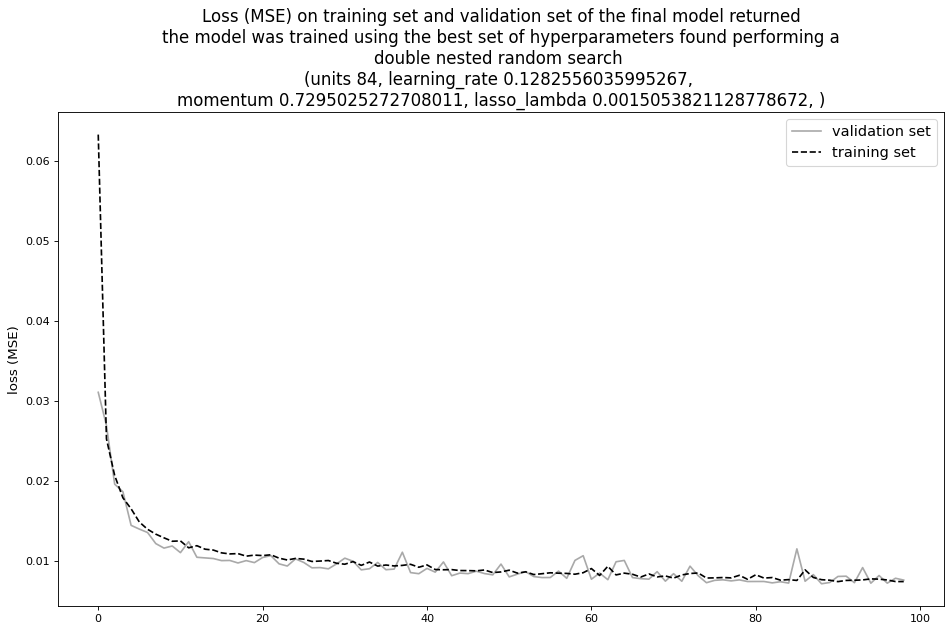

In [82]:
# create a figure
plt.figure(figsize=(12, 8), dpi=80)
    
# define styles for the graph
colours = ["darkgray", "black"]
linestyles = ["solid", "dashed"]

local_path_final_loss = "./plots/ml_cup/nn_RandomSearch/final_model_learning_curve.png"
        
# for each model created plot its learning curve
plt.plot(
    final_history["val_loss"],
    color=colours[0], linestyle=linestyles[0]
)
plt.plot(
    final_history["loss"],
    color=colours[1], linestyle=linestyles[1]
)
        
legend = ["validation set", "training set"]
    
plt.title(
    "Loss (MSE) on training set and validation set of the final model returned\n"
    "the model was trained using the best set of hyperparameters found performing a\ndouble nested random search "
    "" + "\n("
    + labels2 + ")", size=15
)

plt.ylabel("loss (MSE)", size=12)
plt.legend(legend, prop={'size': 13})
plt.tight_layout()
plt.savefig(local_path_final_loss, bbox_inches='tight')
plt.show()

... and its mean Euclidean error during the training process

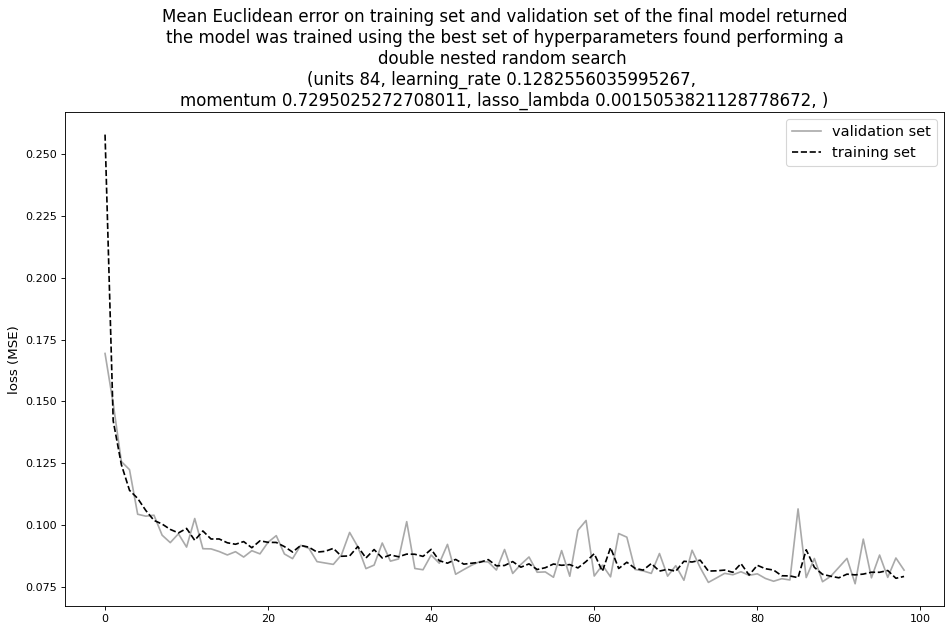

In [83]:
# create a figure
plt.figure(figsize=(12, 8), dpi=80)
    
# define styles for the graph
colours = ["darkgray", "black"]
linestyles = ["solid", "dashed"]

local_path_final_mee = "./plots/ml_cup/nn_RandomSearch/final_model_euclidean_error.png"
        
# for each model created plot its learning curve
plt.plot(
    final_history["val_euclidean_distance"],
    color=colours[0], linestyle=linestyles[0]
)
plt.plot(
    final_history["euclidean_distance"],
    color=colours[1], linestyle=linestyles[1]
)
        
legend = ["validation set", "training set"]
    
plt.title(
    "Mean Euclidean error on training set and validation set of the final model returned\n"
    "the model was trained using the best set of hyperparameters found performing a\ndouble nested random search "
    "" + "\n("
    + labels2 + ")", size=15
)

plt.ylabel("loss (MSE)", size=12)
plt.legend(legend, prop={'size': 13})
plt.tight_layout()
plt.savefig(local_path_final_mee, bbox_inches='tight')
plt.show()

In conclusion, we want to observe the generalization capabilities of our model with respect to the real targets

In [84]:
# predict the targets...

# ... for the whole design set
predicted_target_ds = avg_model_double.predict(x_mlcup_ds)
# ... for the training set 
predicted_target_tr = avg_model_double.predict(x_mlcup_tr)
# ... for the validation set
predicted_target_vl = avg_model_double.predict(x_mlcup_vl)

5/5 [==============================] - 0s 1ms/step


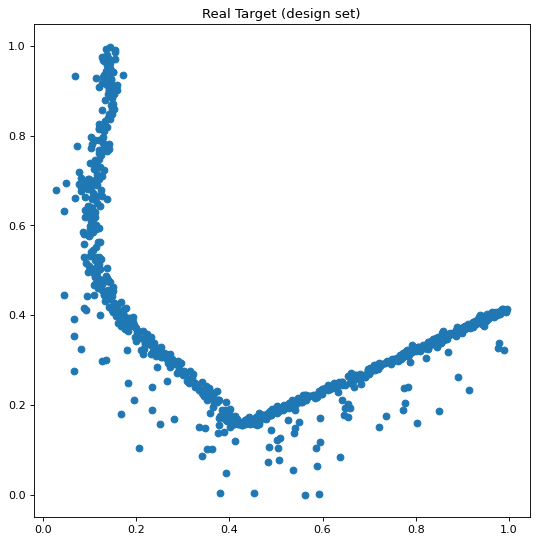

In [85]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(y_mlcup_ds[:, 0], y_mlcup_ds[:, 1])
plt.title("Real Target (design set)")
plt.savefig("./plots/ml_cup/nn_RandomSearch/real_target.png")
plt.show()

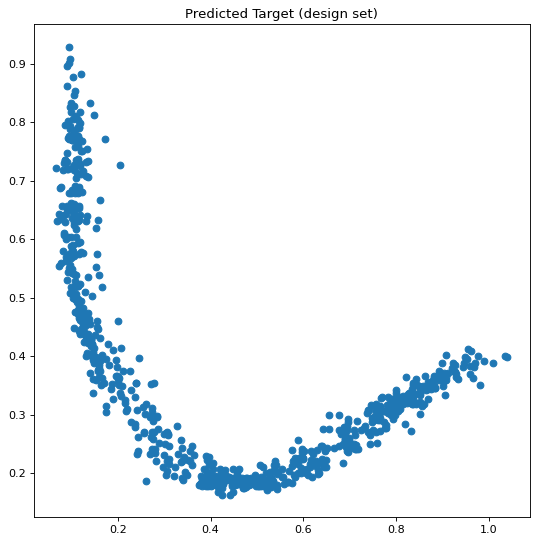

In [86]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_ds[:, 0], predicted_target_ds[:, 1])
plt.title("Predicted Target (design set)")
plt.savefig("./plots/ml_cup/nn_RandomSearch/predicted_target.png")
plt.show()

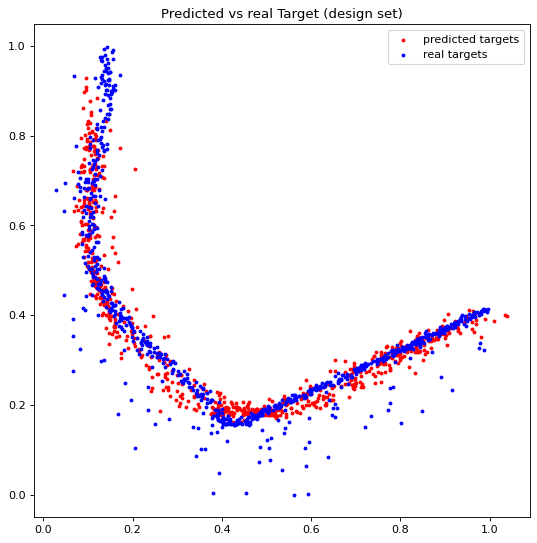

In [87]:
marker_size = 6
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_ds[:, 0], predicted_target_ds[:, 1], s=marker_size, c="red")
plt.scatter(y_mlcup_ds[:, 0], y_mlcup_ds[:, 1], s=marker_size, c="blue")
plt.title("Predicted vs real Target (design set)")

legend = ["predicted targets", "real targets"]
plt.legend(legend)

plt.savefig("./plots/ml_cup/nn_RandomSearch/predicted_vs_real_target.png")
plt.show()


The very last step consists in denormalizing the predicted labels to study which is the final mean Euclidean distance with respect to the real ones. let's start by denormalizing our data

In [88]:
alrDenormalized = False

In [89]:
if (not alrDenormalized):
    # denormalize the training set (real and predicted targets)
    predicted_target_tr = deNormalizer(predicted_target_tr, max_col_value_y, min_col_value_y)
    y_mlcup_tr = deNormalizer(y_mlcup_tr, max_col_value_y, min_col_value_y)
    
    # denormalize the validation set (real and predicted targets)
    predicted_target_vl = deNormalizer(predicted_target_vl, max_col_value_y, min_col_value_y)
    y_mlcup_vl = deNormalizer(y_mlcup_vl, max_col_value_y, min_col_value_y)
    
    alrDenormalized = True

now we can compute the mean Euclidean error

In [90]:
res_tr = compute_mean_euclidean_error(y_mlcup_tr, predicted_target_tr)
res_vl = compute_mean_euclidean_error(y_mlcup_vl, predicted_target_vl)

print("Final mean Euclidean error on the training set: ", res_tr)
print("Final mean Euclidean error on the validation set: ", res_vl)

Final mean Euclidean error on the training set:  1.5731555572870997
Final mean Euclidean error on the validation set:  1.649831238177399


In [ ]:
marker_size = 6

# plotting the results for the training set 

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_tr[:, 0], predicted_target_tr[:, 1], s=marker_size, c="red")
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1], s=marker_size, c="blue")
plt.title("Predicted vs real Target (training set, denormalized data)")

legend = ["predicted targets", "real targets"]
plt.legend(legend)

# plotting the results for the validation set 

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_vl[:, 0], predicted_target_vl[:, 1], s=marker_size, c="red")
plt.scatter(y_mlcup_vl[:, 0], y_mlcup_vl[:, 1], s=marker_size, c="blue")
plt.title("Predicted vs real Target (training set, denormalized data)")

legend = ["predicted targets", "real targets"]
plt.legend(legend)

plt.show()